In [29]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [30]:
#Importing Dataset
df = pd.read_csv("exchange_rate.csv",parse_dates=["date"],index_col="date")

df = df.sort_index()              
df.index.freq = pd.infer_freq(df.index)

In [31]:
# Data Preprocessing: Check Missing Values & Anomalies
print("\nMissing Values Check:\n", df.isnull().sum())

# Fill or remove missing values if present
df["Ex_rate"] = df["Ex_rate"].ffill()

# Check for negative or unrealistic rates
if (df["Ex_rate"] <= 0).any():
    print("\nWarning: Negative or zero exchange rate found - corrected.")
    df["Ex_rate"] = df["Ex_rate"].apply(lambda x: np.nan if x <= 0 else x)
    df["Ex_rate"] = df["Ex_rate"].bfill()



Missing Values Check:
 Ex_rate    0
dtype: int64


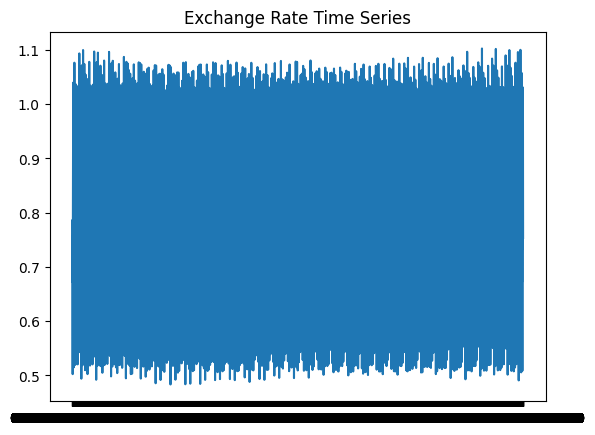

In [32]:
#Exchange rate visualization
ts = df["Ex_rate"]

plt.plot(ts)
plt.title("Exchange Rate Time Series")
plt.show()

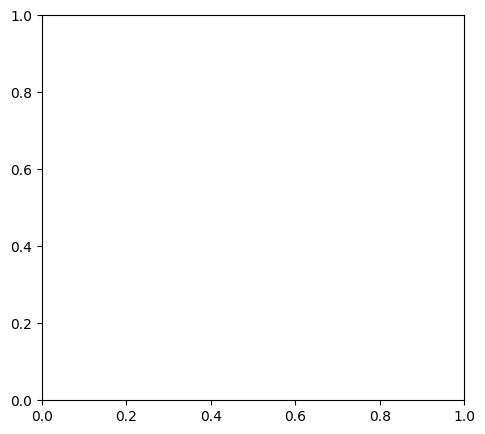

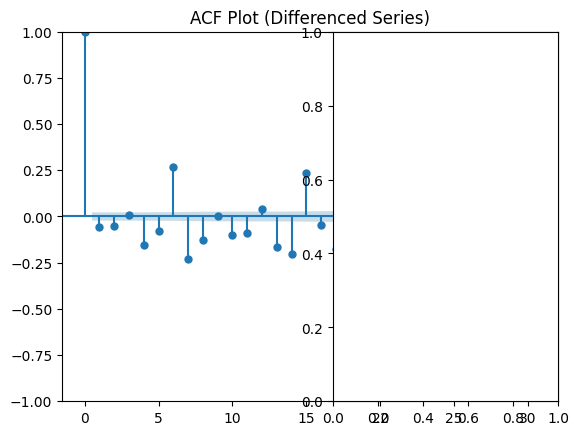

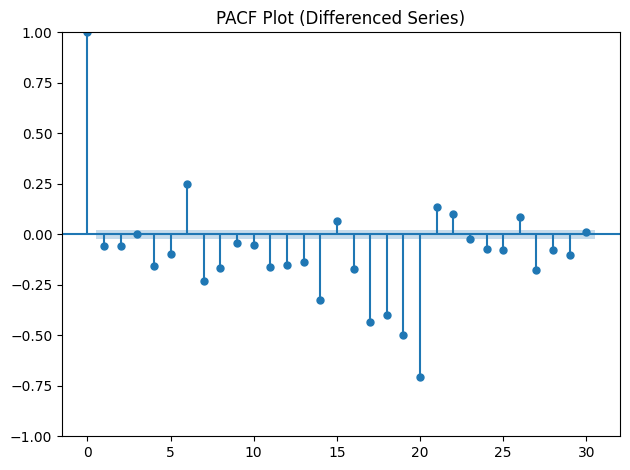

In [33]:
# -------------------------------
# ACF & PACF on DIFFERENCED series
# -------------------------------
ts_diff = ts.diff().dropna()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(ts_diff, lags=30)
plt.title("ACF Plot (Differenced Series)")

plt.subplot(1, 2, 2)
plot_pacf(ts_diff, lags=30, method="ywm")
plt.title("PACF Plot (Differenced Series)")

plt.tight_layout()
plt.show()


In [34]:
train = ts[:-30]
test = ts[-30:]

In [35]:
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None

for order in pdq:
    try:
        model = ARIMA(train, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
    except:
        continue

print("Best ARIMA Order:", best_order)

C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

Best ARIMA Order: (2, 0, 2)


In [36]:
#Create ARIMA model
arima_model = ARIMA(train,order=best_order).fit()
arima_pred = arima_model.forecast(steps=len(test))
arima_pred.index = test.index

C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

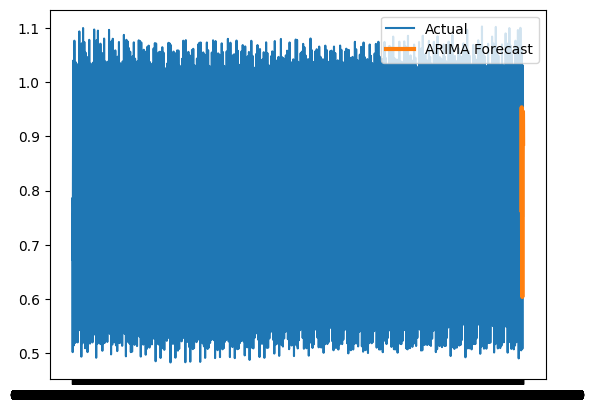

In [37]:
#ARIMA Forecast Visualization
plt.plot(ts,label="Actual")
plt.plot(arima_pred,label="ARIMA Forecast",linewidth=3)
plt.legend()
plt.show()

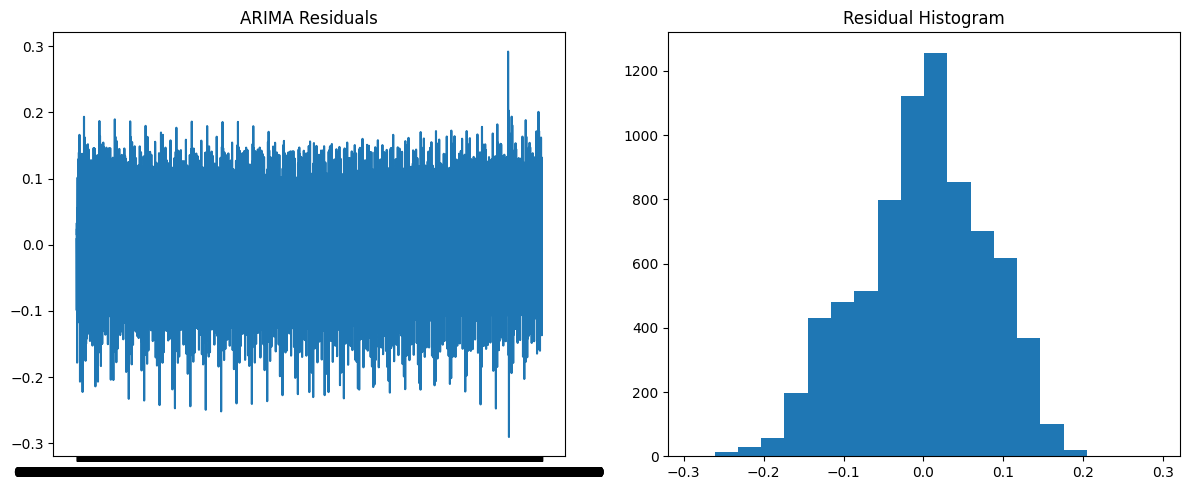

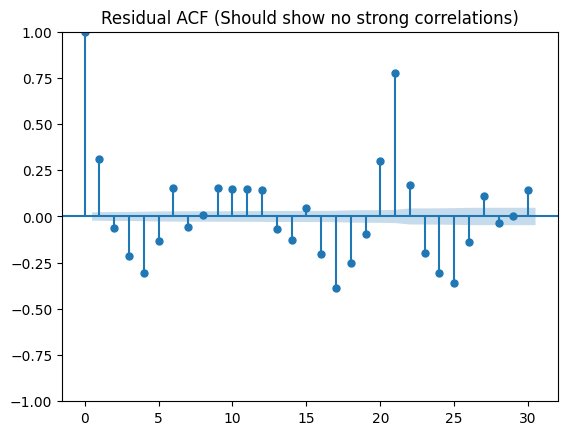


Residual Mean (Should be ~0): -3.6305059568521365e-05


In [38]:
# -------------------------------
# ARIMA Residual Diagnostics
# -------------------------------
residuals = arima_model.resid

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(residuals)
plt.title("ARIMA Residuals")

plt.subplot(1,2,2)
plt.hist(residuals, bins=20)
plt.title("Residual Histogram")
plt.tight_layout()
plt.show()

# Residual ACF plot
plot_acf(residuals, lags=30)
plt.title("Residual ACF (Should show no strong correlations)")
plt.show()

print("\nResidual Mean (Should be ~0):", np.mean(residuals))

C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


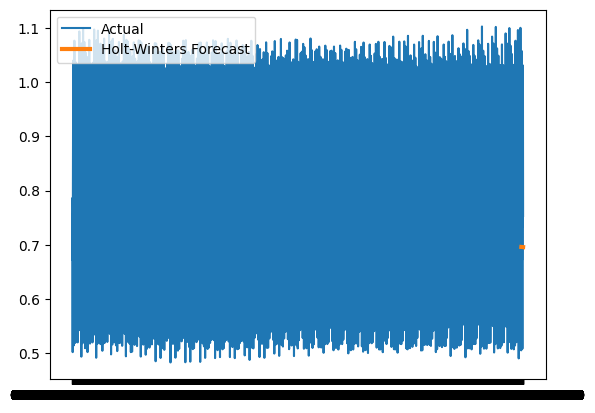

In [40]:
#Creating Holt-Winters model
hw_model = ExponentialSmoothing(train,trend="add").fit()
hw_pred = hw_model.forecast(steps=len(test))
hw_pred.index = test.index

plt.plot(ts,label="Actual")
plt.plot(hw_pred,label="Holt-Winters Forecast",linewidth=3)
plt.legend()
plt.show()

C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



Holt-Winters Optimized Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7558
Model:             ExponentialSmoothing   SSE                             71.020
Optimized:                         True   AIC                         -35244.204
Trend:                         Additive   BIC                         -35133.319
Seasonal:                      Additive   AICC                        -35244.114
Seasonal Periods:                    12   Date:                 Mon, 22 Dec 2025
Box-Cox:                          False   Time:                         12:08:54
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9273140                alpha        

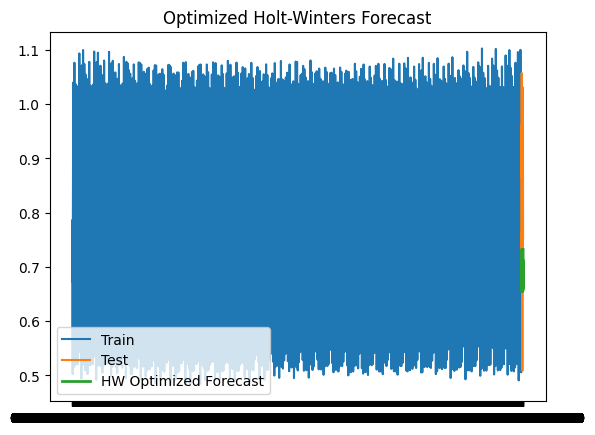

In [41]:
# Optimized Holt-Winters with Trend & Seasonality
# Assuming monthly data with seasonality=12 (adjust if needed)
try:
    hw_model_opt = ExponentialSmoothing(
        train,
        trend="add",
        seasonal="add",
        seasonal_periods=12
    ).fit()

    hw_forecast_opt = hw_model_opt.forecast(len(test))
    hw_forecast_opt.index = test.index

    print("\nHolt-Winters Optimized Model Summary:")
    print(hw_model_opt.summary())

    plt.plot(train, label="Train")
    plt.plot(test, label="Test")
    plt.plot(hw_forecast_opt, label="HW Optimized Forecast", linewidth=2)
    plt.legend()
    plt.title("Optimized Holt-Winters Forecast")
    plt.show()

except Exception as e:
    print("\nHolt-Winters Optimization Error:", e)

In [42]:
#Evaluation Metrics

arima_pred = ARIMA(ts,order=(1,1,1)).fit().forecast(30)
hw_pred = ExponentialSmoothing(ts,trend="add").fit().forecast(30)

arima_pred.index = test.index  
hw_pred.index = test.index

def mape(true,pred) :
    return np.mean(np.abs((true-pred)/true))*100

print("\nARIMA Metrics : \n")
print("\nMAE : ",mean_absolute_error(test,arima_pred))
print("\nRMSE : ",np.sqrt(mean_squared_error(test,arima_pred)))
print("\nMAPE : ",mape(test,arima_pred))

print("\nHolt-Winters Metrics : \n")
print("\nMAE : ",mean_absolute_error(test,hw_pred))
print("\nRMSE : ",np.sqrt(mean_squared_error(test,hw_pred)))
print("\nMAPE : ",mape(test,hw_pred))

C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction resu


ARIMA Metrics : 


MAE :  0.11408075440182931

RMSE :  0.14529590025288683

MAPE :  14.034081946955718

Holt-Winters Metrics : 


MAE :  0.11575057526425028

RMSE :  0.1508995526433386

MAPE :  13.903080049303549


C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Aarush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#Data Visualization
plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(arima_pred,label="ARIMA Forecast",linewidth=2)
plt.plot(hw_pred,label="HW Forecast",linewidth=2)
plt.legend()
plt.title("Forecast Comparison")
plt.show()

In [ ]:
# -------------------------------
# Model Comparison
# -------------------------------
print("\nModel Comparison Based on Metrics:")
print("--------------------------------------------------")
print("Model       | MAE       | RMSE      | MAPE")
print("--------------------------------------------------")
print("ARIMA       | {:.4f}   | {:.4f}   | {:.2f}%".format(
    mean_absolute_error(test, arima_pred),
    np.sqrt(mean_squared_error(test, arima_pred)),
    mape(test, arima_pred)
))
print("Holt-Winters| {:.4f}   | {:.4f}   | {:.2f}%".format(
    mean_absolute_error(test, hw_pred),
    np.sqrt(mean_squared_error(test, hw_pred)),
    mape(test, hw_pred)
))
print("\nAdvantages & Limitations:")
print("ARIMA: Good for short-term linear trends, but struggles with seasonal patterns.")
print("Holt-Winters: Handles trends and seasonality well, but may overfit if parameters not tuned.")


In [ ]:
# -------------------------------
# Conclusion
# -------------------------------
print("\nConclusion:")
print("Based on evaluation metrics, the model with lower MAE, RMSE, and MAPE is preferred for forecasting.")
print("If ARIMA has lower error, it is suitable for short-term forecasts without strong seasonality.")
print("If Holt-Winters performs better, it is more effective for capturing trends and seasonal patterns.")
print("Overall, the choice depends on dataset characteristics and forecast horizon.")

In [ ]:
print("\nExplanation of Model Selection Steps:")

print("\n1. ACF/PACF for ARIMA:")
print("- ACF helps identify the MA(q) part.")
print("- PACF helps identify the AR(p) part.")
print("- Differencing (d) ensures stationarity.")

print("\n2. Missing Value & Anomaly Handling:")
print("- Exchange rates must be positive and continuous.")
print("- Forward fill ensures no gaps in time series.")

print("\n3. ARIMA Diagnostics:")
print("- Residual plots ensure errors are random.")
print("- No autocorrelation in residual ACF indicates a valid model.")

print("\n4. Holt-Winters Optimization:")
print("- Trend='add' captures linear trend.")
print("- seasonal_periods helps capture repeated seasonal patterns.")
print("- Tested additive trend + additive seasonality for better realism.")

print("\n5. Final Model Choice:")
print("- Lower MAE, RMSE, and MAPE determine the better forecasting model.")
